# Race Logs

This notebook is used to view, update, and manage the set of race/sail instrument logs collected on Peer Gynt using the Raspberry Pi.

Information about the race logs are collected into a Pandas dataframe (which is much like a database).  Why not use a database?  Because then we can share "know how" and some tools.

## Goals

- View the list of all logs and inspect for accuracy.
    - Correct errors
- Update and add a new log
- Add meta data (like race start/end)
- View race data.

## TODO

- Add additional metadata for each race.  Some extracted automatically?
   - Tenet: this data should be user entered, not automatic.  Automatic goes in a separate table?
   - Conditions.  Crew.  Settings for rig.
   - Speed. Quality of maneuvers.
- How to edit more complex and longer text fields.
- How to handle multiple races in one log??
   - Split into different files?
- Make it faster to show the race track.
- What if I want to permanently delete a log?  
- How can I tell if the log is a duplicate?


In [1]:
%matplotlib notebook

import os
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qgrid

# These are libraries written for RaceAnalysis
import global_variables
G = global_variables.init_seattle()
import race_logs
import process as p
import analysis as a
import chart as c
import utils

In [2]:
# Info about the race logs are stored in a DataFrame.
log_info = race_logs.read_log_info()

# The data in this table can be editted using a QGrid Control.  Click on the column header to sort.  Click again 
# to sort in a different order.  Double click on a cell to edit.
w = qgrid.show_grid(log_info, show_toolbar=True)
w


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [3]:
# If you do update the table shown above, then this will save the changes (which are not saved by default)

if False:  # False for now.
    log_info = w.get_changed_df()
    race_logs.save_updated_log_info(log_info)

In [4]:
# Check to see if there are newly collected logs.  The log files will exist, but there will be 
# no corresponding rows.

missing_files = race_logs.find_new_logs(log_info)
print("Here are a list of files which are missing from the log_info table.")
missing_files

Here are a list of files which are missing from the log_info table.


[]

In [5]:
# Load each of the new log files.

if len(missing_files) > 0:
    # Load these new log files
    new_dfs = []
    for file in missing_files:
        print(f"Loading {file}")
        ndf = race_logs.read_log_file(file, discard_columns=True, skip_dock_only=False, trim=True, path=G.LOGS_DIRECTORY, cutoff=0.3)
        ndf.filename = file
        new_dfs.append(ndf)

    # As a convenience combine the new logs into one large DataFrame
    bdf =  pd.concat(new_dfs, sort=True, ignore_index=True)

<IPython.core.display.Javascript object>


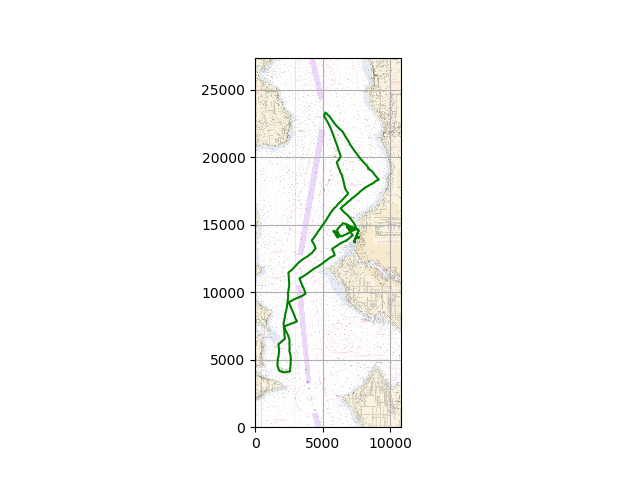

Displaying in 2020-03-07_08:28.pd.gz in red
Displaying in 2020-03-07_09:28.pd.gz in green


In [35]:
# Display each new race log on a map, to jog your memory.

if len(missing_files) > 0:

    # Create a chart that can contain all the tracks.
    chart = c.plot_chart(bdf)

    # Plot each in a different color.
    for df, color in zip(new_dfs, it.cycle("red green blue brown grey".split())):
        print(f"Displaying in {df.filename} in {color}")
        c.draw_track(df, chart, color=color)


## Trimming the data 

The logs start from the time we power up until we shutdown.  And this typically inclues 30-90 mins at the dock (or more).

The UI below (which is sort of unreliable right now) can be used to find the trim points.

On the left are two "sliders" (primitive, I know).  The first is used to determine the beginning of the data to show.  The second the end.  When you are done, the results are stored in `ch.begin` and `ch.end`.

Note, for some reason the UI freezes.  If so,  you can just re-run the command.  

<IPython.core.display.Javascript object>


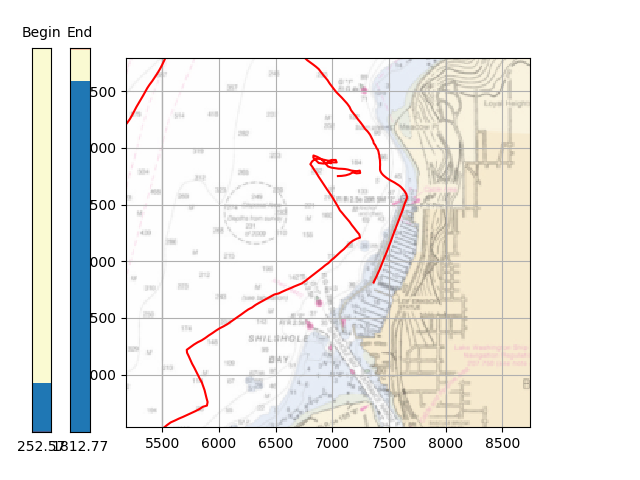

In [41]:
df = new_dfs[1]
ch = c.plot_track(df)

In [42]:
ch.begin, ch.end

(26719, 192079)

In [43]:
# Display the newly modified table, and perhpas edit to fill in missing info.

if len(missing_files) > 0:
    new_log_info = race_logs.add_log_info_rows(log_info, missing_files)        
   
    # The data in this table can be editted using a QGrid Control.  Double click on a cell to edit.
    w = qgrid.show_grid(new_log_info, show_toolbar=True)
    display(w)

Adding 2020-03-07_08:28.pd.gz
Adding 2020-03-07_09:28.pd.gz


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [46]:
# Save the new table.
if len(missing_files) > 0:

    log_info = w.get_changed_df()
    race_logs.save_updated_log_info(log_info)


Backed up log info data to Data/Backup/log_info.pd_00


In [47]:
log_info

,file,race,begin,end,datetime,description
0,2020-02-08_10:23.pd.gz,Snowbird #4,32000,130010,2020-02-08 10:23:00-08:00,Snowbird #4.
1,2020-01-25_14:23.pd.gz,STYC Iceberg,0,-1,2020-01-25 14:23:00-08:00,"Lot's of wind was predicted, but we got little..."
2,2020-01-18_10:50.pd.gz,,0,-1,2020-01-18 10:50:00-08:00,Practice
3,2019-12-07_09:47.pd.gz,Snowbird #2,54316,109378,2019-12-07 09:47:00-08:00,Snowbird #2.
4,2019-12-06_11:25.pd.gz,,0,-1,2019-12-06 11:25:00-08:00,"Short, at dock."
5,2019-11-29_12:54.pd.gz,,0,-1,2019-11-29 12:54:00-08:00,Longer. At dock for data collection.
6,2019-11-24_10:33.pd.gz,,0,-1,2019-11-24 10:33:00-08:00,Practice.
7,2019-11-23_10:23.pd.gz,,0,-1,2019-11-23 10:23:00-08:00,Practice.
8,2019-11-16_10:09.pd.gz,Snowbird #1,41076,111668,2019-11-16 10:09:00-08:00,Snowbird #1.
9,2019-11-07_12:46.pd.gz,,0,-1,2019-11-07 12:46:00-08:00,"Short, at dock."


## Quick Visualization Interface

Below we have added a bit of additional functionality to the qgrid interface:  When you select a row, that race track will be shown automatically.

Note, it takes a second (or two) between selecting a row and the display.  Its one of the only things that are a bit slow.

<IPython.core.display.Javascript object>


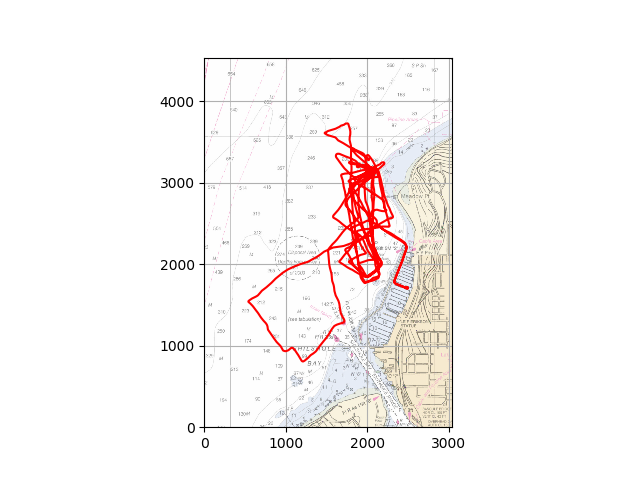

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

displaying file: 2020-02-08_10:23.pd.gz
Session from 2020-02-08 18:23:28.070000, 141790 rows, 4.152222222222222 hours.
displaying file: 2020-02-29_10:24.pd.gz
Session from 2020-02-29 18:24:43.060000, 145790 rows, 4.049444444444444 hours.


In [24]:
# create a function that is called "back" when a row is selected
def show_helper(row_num):
    "Display the race track from the ROW_NUM row, by position."
    file = log_info.iloc[row_num].file
    print(f"displaying file: {file}")
    df = race_logs.read_log_file(file, discard_columns=True, skip_dock_only=False, trim=True, path=G.LOGS_DIRECTORY, cutoff=0.3)
    chart = c.plot_chart(df, fig_or_num=fig)
    c.draw_track(df, chart, color='red')  

def show(args, _):
    # Args are a bit obscure
    row_num = args['new'][0]  # The newly selected row numbers, selected the first
    show_helper(row_num)

fig = plt.figure()
w = qgrid.show_grid(log_info, show_toolbar=True)
display(w)

# Display one of the races.
show_helper(0)

# Bind the callback
w.on('selection_changed', show)
